In [77]:
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt


In [78]:
# Load and parse annotations
def load_annotations(annotation_file):
    print(f"Loading annotations from {annotation_file}")
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)
    print(f"Loaded {len(annotations['annotations'])} annotations")
    return annotations

def parse_keypoints(annotations, label):
    data = []
    for ann in annotations['annotations']:
        keypoints = ann['keypoints']
        keypoints_array = np.array(keypoints).reshape(-1, 3)
        coords = keypoints_array[:, :2]
        visibility = keypoints_array[:, 2]
        data.append((coords, visibility, label))
    print(f"Parsed {len(data)} keypoints with label {label}")
    return data

# Load annotations
correct_annotations = load_annotations('annotations_v3/n6-269-299-correct.json')
incorrect_annotations = load_annotations('annotations_v3/lumbar-neth-K-1.1-285-w53445.json')

# Parse keypoints
correct_data = parse_keypoints(correct_annotations, label=1)
incorrect_data = parse_keypoints(incorrect_annotations, label=0)

# Combine and split data
all_data = correct_data + incorrect_data
print(f"Total data points: {len(all_data)}")
train_data, val_data = train_test_split(all_data, test_size=0.2, random_state=42)
print(f"Training data points: {len(train_data)}, Validation data points: {len(val_data)}")


Loading annotations from annotations_v3/n6-269-299-correct.json
Loaded 300 annotations
Loading annotations from annotations_v3/lumbar-neth-K-1.1-285-w53445.json
Loaded 286 annotations
Parsed 300 keypoints with label 1
Parsed 286 keypoints with label 0
Total data points: 586
Training data points: 468, Validation data points: 118


In [79]:
# Define custom dataset
class PoseDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        coords, visibility, label = self.data[idx]
        coords_tensor = torch.tensor(coords, dtype=torch.float)
        visibility_tensor = torch.tensor(visibility, dtype=torch.float)
        label_tensor = torch.tensor(label, dtype=torch.long)
        # Define edge_index for the pose graph
        edge_index = torch.tensor([
            [0, 1], [1, 0],  # nose - left eye
            [0, 2], [2, 0],  # nose - right eye
            [1, 3], [3, 1],  # left eye - left ear
            [2, 4], [4, 2],  # right eye - right ear
            [5, 6], [6, 5],  # left shoulder - right shoulder
            [5, 7], [7, 5],  # left shoulder - left elbow
            [6, 8], [8, 6],  # right shoulder - right elbow
            [7, 9], [9, 7],  # left elbow - left wrist
            [8, 10], [10, 8],  # right elbow - right wrist
            [5, 11], [11, 5],  # left shoulder - left hip
            [6, 12], [12, 6],  # right shoulder - right hip
            [11, 12], [12, 11],  # left hip - right hip
            [11, 13], [13, 11],  # left hip - left knee
            [12, 14], [14, 12],  # right hip - right knee
            [13, 15], [15, 13],  # left knee - left ankle
            [14, 16], [16, 14],  # right knee - right ankle
        ], dtype=torch.long).t().contiguous()
        return Data(x=coords_tensor, edge_index=edge_index, y=label_tensor)

# Create datasets
train_dataset = PoseDataset(train_data)
val_dataset = PoseDataset(val_data)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [80]:
# Define the original GCN model
class PoseGCN(torch.nn.Module):
    def __init__(self, num_node_features):
        super(PoseGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.linear = torch.nn.Linear(64, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, data.batch)
        x = self.linear(x)
        return F.log_softmax(x, dim=1)


In [81]:
# Define the deep GCN model
class DeepPoseGCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels=64, num_classes=2):
        super(DeepPoseGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn3 = torch.nn.BatchNorm1d(hidden_channels)
        self.linear1 = torch.nn.Linear(hidden_channels, hidden_channels//2)
        self.linear2 = torch.nn.Linear(hidden_channels//2, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)
        x1 = F.dropout(x1, p=0.2, training=self.training)
        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(x2)
        x2 = F.relu(x2)
        x2 = F.dropout(x2, p=0.2, training=self.training)
        x2 = x2 + x1
        x3 = self.conv3(x2, edge_index)
        x3 = self.bn3(x3)
        x3 = F.relu(x3)
        x3 = F.dropout(x3, p=0.2, training=self.training)
        x3 = x3 + x2
        x4 = self.conv4(x3, edge_index)
        x = global_mean_pool(x4, data.batch)
        x = F.relu(self.linear1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)


In [82]:
# Training function
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    predictions = []
    labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            loss = criterion(output, data.y)
            total_loss += loss.item()
            pred = output.max(1)[1]
            correct += pred.eq(data.y).sum().item()
            predictions.extend(pred.cpu().numpy())
            labels.extend(data.y.cpu().numpy())
    accuracy = correct / len(loader.dataset)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return accuracy, precision, recall, f1


In [83]:
# Define the training and evaluation function
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, num_epochs=100, device='cpu', 
                       checkpoint_dir='models', model_name='Model'):
    best_f1 = 0
    train_losses = []
    val_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    learning_rates = [optimizer.param_groups[0]['lr']]  # Track learning rates
    
    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    epoch_checkpoints = [10, 20, 50, 75]  # Save at these specific epochs
    
    for epoch in range(num_epochs):
        # Train
        train_loss = train(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)
        
        # Evaluate
        val_acc, val_prec, val_rec, val_f1 = validate(model, val_loader, criterion, device)
        
        # Store metrics
        val_metrics['accuracy'].append(val_acc)
        val_metrics['precision'].append(val_prec)
        val_metrics['recall'].append(val_rec)
        val_metrics['f1'].append(val_f1)
        
        # Print progress with model name
        print(f'\n{model_name} - Epoch {epoch+1:03d}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Val Accuracy: {val_acc:.4f}, Precision: {val_prec:.4f}, '
              f'Recall: {val_rec:.4f}, F1: {val_f1:.4f}')
        
        # Save best model whenever a new best F1 score is achieved
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_metrics': val_metrics,
                'train_losses': train_losses,
                'learning_rate': optimizer.param_groups[0]['lr'],
                'learning_rates': learning_rates
            }, f'{checkpoint_dir}/model_{model.__class__.__name__}_best.pth')
            print(f"Saved best {model_name} with F1: {val_f1:.4f}")
        
        # Save checkpoint at specific epoch milestones
        if (epoch + 1) in epoch_checkpoints:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_metrics': val_metrics,
                'train_losses': train_losses,
                'learning_rate': optimizer.param_groups[0]['lr'],
                'learning_rates': learning_rates
            }, f'{checkpoint_dir}/model_{model.__class__.__name__}_epoch_{epoch+1}.pth')
            print(f"Saved checkpoint for {model_name} at epoch {epoch+1}")
    
    return train_losses, val_metrics, learning_rates

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train Original PoseGCN
print("\n=== Training Original PoseGCN ===")
original_model = PoseGCN(num_node_features=2).to(device)
original_optimizer = torch.optim.Adam(original_model.parameters(), lr=0.001)

original_train_losses, original_val_metrics, original_learning_rates = train_and_evaluate(
    original_model, train_loader, val_loader, original_optimizer, criterion,
    num_epochs=100, device=device, checkpoint_dir='models/original',
    model_name='Original PoseGCN'
)

# Train Deep PoseGCN
print("\n=== Training Deep PoseGCN ===")
deep_model = DeepPoseGCN(num_node_features=2).to(device)
deep_optimizer = torch.optim.Adam(deep_model.parameters(), lr=0.001)

deep_train_losses, deep_val_metrics, deep_learning_rates = train_and_evaluate(
    deep_model, train_loader, val_loader, deep_optimizer, criterion,
    num_epochs=100, device=device, checkpoint_dir='models/deep',
    model_name='Deep PoseGCN'
)


=== Training Original PoseGCN ===

Original PoseGCN - Epoch 001/100:
Train Loss: 2.3327
Val Accuracy: 0.4407, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


c:\Users\UDESIAS\Documents\FYP\GCN-Mar8\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Original PoseGCN - Epoch 002/100:
Train Loss: 2.0530
Val Accuracy: 0.4915, Precision: 0.5938, Recall: 0.2879, F1: 0.3878
Saved best Original PoseGCN with F1: 0.3878

Original PoseGCN - Epoch 003/100:
Train Loss: 1.5855
Val Accuracy: 0.4915, Precision: 1.0000, Recall: 0.0909, F1: 0.1667

Original PoseGCN - Epoch 004/100:
Train Loss: 1.2156
Val Accuracy: 0.5593, Precision: 0.5593, Recall: 1.0000, F1: 0.7174
Saved best Original PoseGCN with F1: 0.7174

Original PoseGCN - Epoch 005/100:
Train Loss: 1.1395
Val Accuracy: 0.5593, Precision: 0.5593, Recall: 1.0000, F1: 0.7174

Original PoseGCN - Epoch 006/100:
Train Loss: 0.9784
Val Accuracy: 0.5593, Precision: 0.5593, Recall: 1.0000, F1: 0.7174

Original PoseGCN - Epoch 007/100:
Train Loss: 1.0622
Val Accuracy: 0.4831, Precision: 1.0000, Recall: 0.0758, F1: 0.1408

Original PoseGCN - Epoch 008/100:
Train Loss: 0.8680
Val Accuracy: 0.4661, Precision: 1.0000, Recall: 0.0455, F1: 0.0870

Original PoseGCN - Epoch 009/100:
Train Loss: 0.9554
Val 

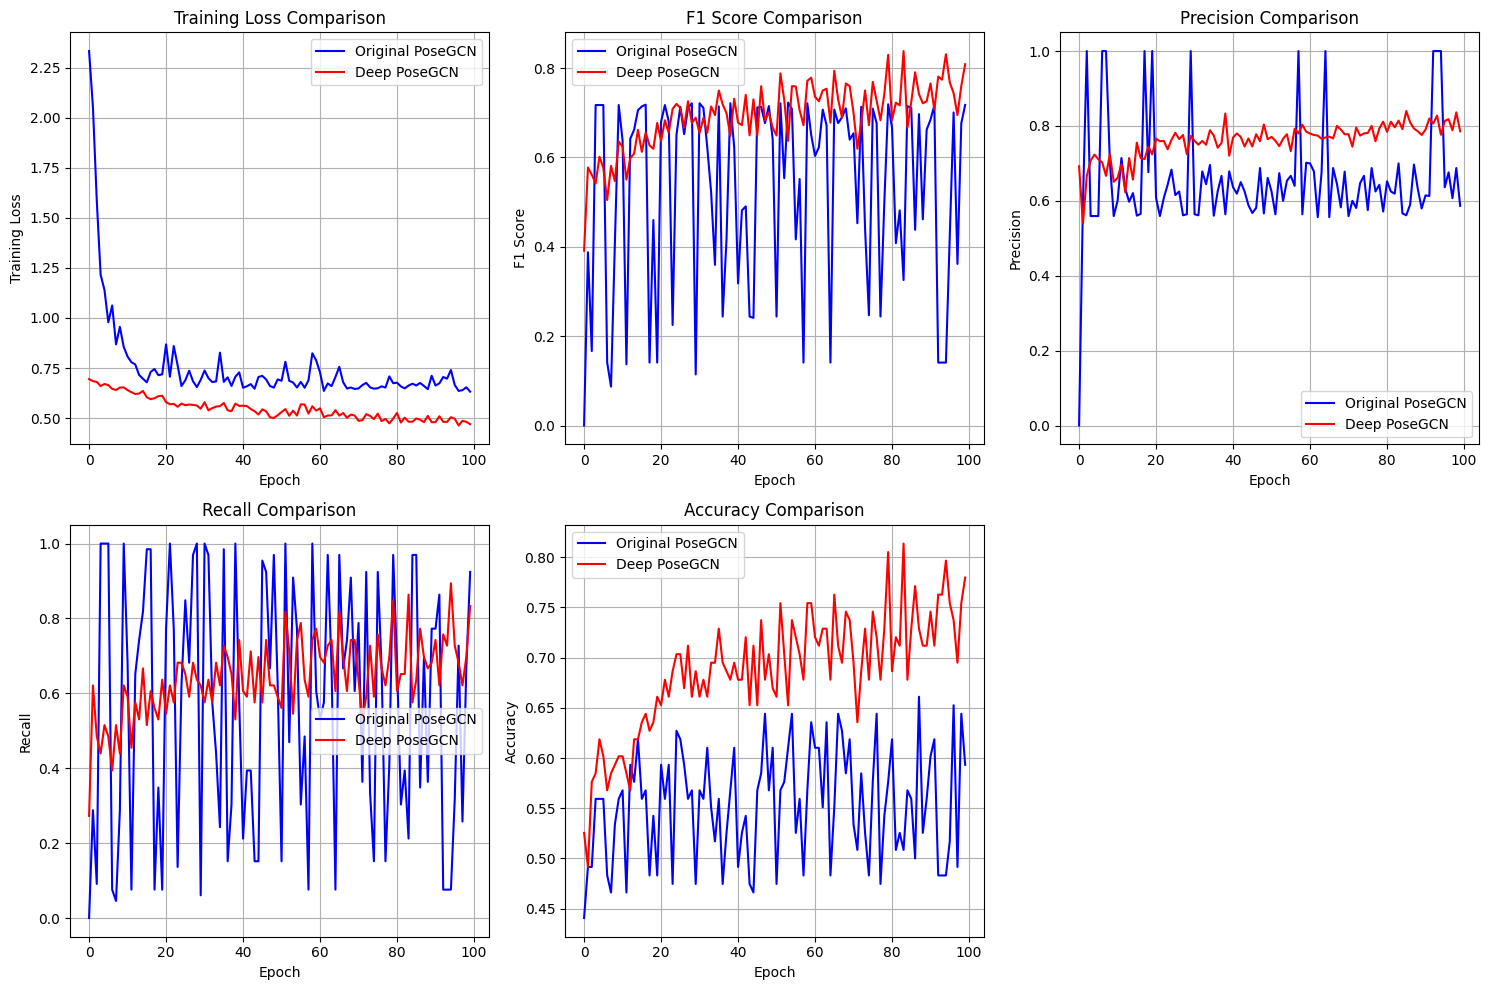

In [90]:
# Visualization and Comparison
plt.figure(figsize=(15, 10))

# Plot training loss comparison
plt.subplot(2, 3, 1)
plt.plot(original_train_losses, 'b-', label='Original PoseGCN')
plt.plot(deep_train_losses, 'r-', label='Deep PoseGCN')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.grid(True)
plt.legend()

# Plot F1 Score comparison
plt.subplot(2, 3, 2)
plt.plot(original_val_metrics['f1'], 'b-', label='Original PoseGCN')
plt.plot(deep_val_metrics['f1'], 'r-', label='Deep PoseGCN')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison')
plt.grid(True)
plt.legend()

# Plot precision comparison
plt.subplot(2, 3, 3)
plt.plot(original_val_metrics['precision'], 'b-', label='Original PoseGCN')
plt.plot(deep_val_metrics['precision'], 'r-', label='Deep PoseGCN')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision Comparison')
plt.grid(True)
plt.legend()

# Plot recall comparison
plt.subplot(2, 3, 4)
plt.plot(original_val_metrics['recall'], 'b-', label='Original PoseGCN')
plt.plot(deep_val_metrics['recall'], 'r-', label='Deep PoseGCN')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall Comparison')
plt.grid(True)
plt.legend()

# Plot accuracy comparison
plt.subplot(2, 3, 5)
plt.plot(original_val_metrics['accuracy'], 'b-', label='Original PoseGCN')
plt.plot(deep_val_metrics['accuracy'], 'r-', label='Deep PoseGCN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.grid(True)
plt.legend()

# # Plot learning rate comparison
# plt.subplot(2, 3, 6)
# plt.plot(original_learning_rates, 'b-', label='Original PoseGCN')
# plt.plot(deep_learning_rates, 'r-', label='Deep PoseGCN')
# plt.xlabel('Epoch')
# plt.ylabel('Learning Rate')
# plt.title('Learning Rate Comparison')
# plt.grid(True)
# plt.legend()

plt.tight_layout()
plt.savefig('models/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



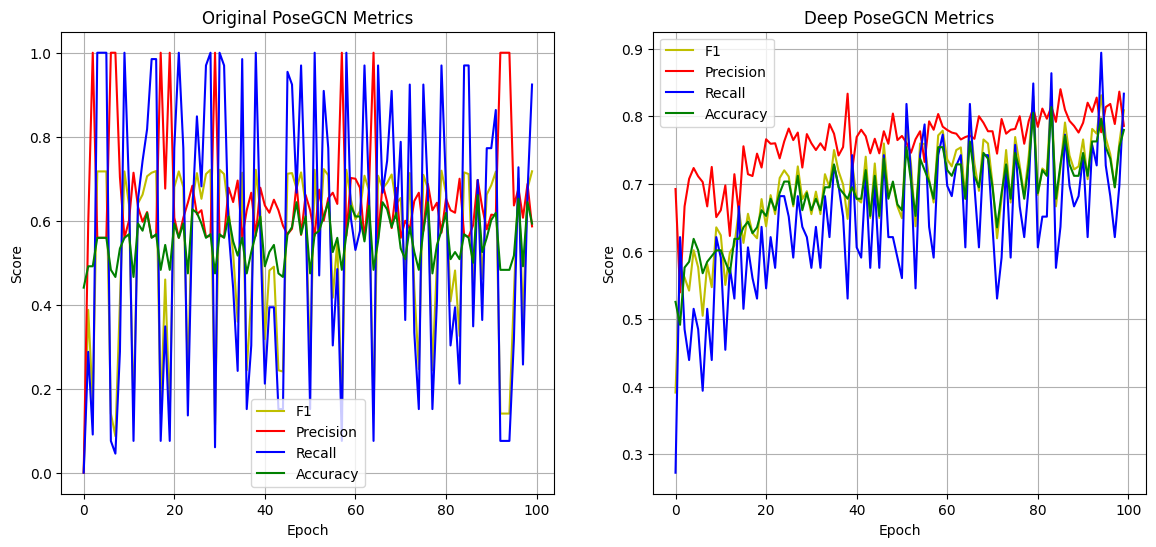

In [101]:
# Create a combined plot of all metrics for each model
plt.figure(figsize=(14, 6))


# Plot all metrics for original model
plt.subplot(1, 2, 1)
plt.plot(original_val_metrics['f1'], 'y-', label='F1')
plt.plot(original_val_metrics['precision'], 'r-', label='Precision')
plt.plot(original_val_metrics['recall'], 'b-', label='Recall')
plt.plot(original_val_metrics['accuracy'], 'g-', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Original PoseGCN Metrics')
plt.grid(True)
plt.legend()

# Plot all metrics for deep model
plt.subplot(1, 2, 2)
plt.plot(deep_val_metrics['f1'], 'y-', label='F1')
plt.plot(deep_val_metrics['precision'], 'r-', label='Precision')
plt.plot(deep_val_metrics['recall'], 'b-', label='Recall')
plt.plot(deep_val_metrics['accuracy'], 'g-', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Deep PoseGCN Metrics')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('models/all_metrics_by_model.png')
plt.show()

In [89]:
# Print detailed comparison
print("\n=== Model Comparison ===")
print(f"Original PoseGCN - Best F1: {max(original_val_metrics['f1']):.4f}")
print(f"Deep PoseGCN - Best F1: {max(deep_val_metrics['f1']):.4f}")

print("\n=== Best Metrics Comparison ===")
print("Original PoseGCN:")
print(f"  Best Precision: {max(original_val_metrics['precision']):.4f}")
print(f"  Best Recall: {max(original_val_metrics['recall']):.4f}")
print(f"  Best Accuracy: {max(original_val_metrics['accuracy']):.4f}")

print("\nDeep PoseGCN:")
print(f"  Best Precision: {max(deep_val_metrics['precision']):.4f}")
print(f"  Best Recall: {max(deep_val_metrics['recall']):.4f}")
print(f"  Best Accuracy: {max(deep_val_metrics['accuracy']):.4f}")

# Find best epochs
original_best_f1_epoch = np.argmax(original_val_metrics['f1'])
deep_best_f1_epoch = np.argmax(deep_val_metrics['f1'])

print("\n=== Best Model Details ===")
print(f"Original PoseGCN - Best epoch: {original_best_f1_epoch+1}")
print(f"  F1: {original_val_metrics['f1'][original_best_f1_epoch]:.4f}")
print(f"  Precision: {original_val_metrics['precision'][original_best_f1_epoch]:.4f}")
print(f"  Recall: {original_val_metrics['recall'][original_best_f1_epoch]:.4f}")
print(f"  Accuracy: {original_val_metrics['accuracy'][original_best_f1_epoch]:.4f}")

print(f"\nDeep PoseGCN - Best epoch: {deep_best_f1_epoch+1}")
print(f"  F1: {deep_val_metrics['f1'][deep_best_f1_epoch]:.4f}")
print(f"  Precision: {deep_val_metrics['precision'][deep_best_f1_epoch]:.4f}")
print(f"  Recall: {deep_val_metrics['recall'][deep_best_f1_epoch]:.4f}")
print(f"  Accuracy: {deep_val_metrics['accuracy'][deep_best_f1_epoch]:.4f}")

# Conclusions
print("\n=== Conclusions ===")
print("1. Model Performance Comparison:")
print(f"   - Original PoseGCN achieved best F1: {max(original_val_metrics['f1']):.4f}")
print(f"   - Deep PoseGCN achieved best F1: {max(deep_val_metrics['f1']):.4f}")
print("\n2. Training Characteristics:")
print(f"   - Original PoseGCN best performance at epoch {original_best_f1_epoch+1}")
print(f"   - Deep PoseGCN best performance at epoch {deep_best_f1_epoch+1}")




=== Model Comparison ===
Original PoseGCN - Best F1: 0.7229
Deep PoseGCN - Best F1: 0.8382

=== Best Metrics Comparison ===
Original PoseGCN:
  Best Precision: 1.0000
  Best Recall: 1.0000
  Best Accuracy: 0.6610

Deep PoseGCN:
  Best Precision: 0.8400
  Best Recall: 0.8939
  Best Accuracy: 0.8136

=== Best Model Details ===
Original PoseGCN - Best epoch: 54
  F1: 0.7229
  Precision: 0.6000
  Recall: 0.9091
  Accuracy: 0.6102

Deep PoseGCN - Best epoch: 84
  F1: 0.8382
  Precision: 0.8143
  Recall: 0.8636
  Accuracy: 0.8136

=== Conclusions ===
1. Model Performance Comparison:
   - Original PoseGCN achieved best F1: 0.7229
   - Deep PoseGCN achieved best F1: 0.8382

2. Training Characteristics:
   - Original PoseGCN best performance at epoch 54
   - Deep PoseGCN best performance at epoch 84
